In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Load the titanic dataset
You will use the Titanic dataset with the (rather morbid) goal of predicting passenger survival, given characteristics such as gender, age, class, etc.

In [2]:
import tensorflow as tf

In [3]:
# Load dataset.
dftrain = pd.read_csv('titanic_train.csv')
dfeval = pd.read_csv('titanic_test.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## Explore the data

The dataset contains the following features

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


There are 627 and 264 examples in the training and evaluation sets, respectively.

In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

The majority of passengers are in their 20's and 30's.

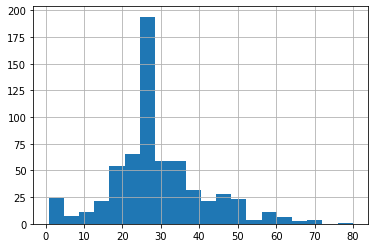

In [7]:
dftrain.age.hist(bins=20)

There are approximately twice as many male passengers as female passengers aboard.

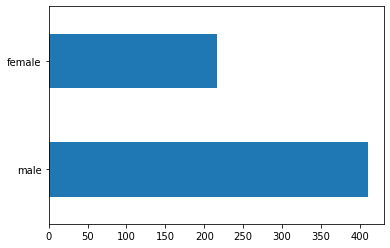

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

The majority of passengers were in the "third" class.

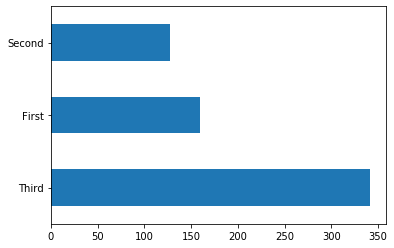

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

Females have a much higher chance of surviving versus males. This is clearly a predictive feature for the model.

Text(0.5, 0, '% survive')

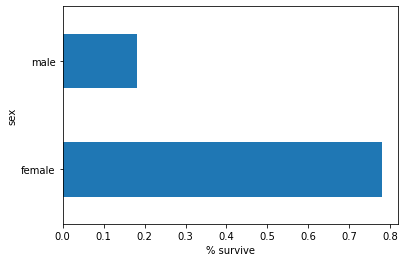

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## Feature Engineering for the Model
Estimators use a system called [feature columns](https://www.tensorflow.org/guide/feature_columns) to describe how the model should interpret each of the raw input features. An Estimator expects a vector of numeric inputs, and *feature columns* describe how the model should convert each feature.

Selecting and crafting the right set of feature columns is key to learning an effective model. A feature column can be either one of the raw inputs in the original features `dict` (a *base feature column*), or any new columns created using transformations defined over one or multiple base columns (a *derived feature columns*).

The linear estimator uses both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.

### Base Feature Columns

In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

The `input_function` specifies how data is converted to a `tf.data.Dataset` that feeds the input pipeline in a streaming fashion. `tf.data.Dataset` can take in multiple sources such as a dataframe, a csv-formatted file, and more.

In [12]:
def train_and_eval_fn(features, labels, training=False, batch_size=256):
    """An input function for training or evaluating"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)

def predict_fn(features, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features)))
    return dataset.batch(batch_size)

After adding all the base features to the model, let's train the model. Training a model is just a single command using the `tf.estimator` API:

In [13]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# Train the Model.
linear_est.train(
    input_fn=lambda: train_and_eval_fn(dftrain, y_train, training=True),
    steps=5000)

eval_result = linear_est.evaluate(
    input_fn=lambda: train_and_eval_fn(dfeval, y_eval))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\archi\\AppData\\Local\\Temp\\tmp6zdcx7d9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_v

C:\Users\archi\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\archi\AppData\Local\Temp\tmp6zdcx7d9\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931473, step = 0
INFO:tensorflow:global_step/sec: 228.91
INFO:tensorflow:loss = 0.4244599, step = 100 (0.438 sec)
INFO:tensorflow:global_step/sec: 342.073
INFO:tensorflow:loss = 0.41326934, step = 200 (0.293 sec)
INFO:tensorflow:global_step/sec: 262.237
INFO:tensorflow:loss = 0.3940191, step = 300 (0.381 sec)
INFO:tensorflow:global_step/sec: 191.35
INFO:tensorflow:loss = 0.41751075, step = 400 (0.

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier,  the `eval_input_fn` was  defined using the entire evaluation set.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\archi\AppData\Local\Temp\tmp6zdcx7d9\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


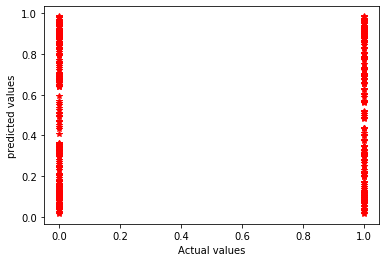

In [14]:
import numpy as np
predictions=[]
for pred in linear_est.predict(input_fn=lambda: predict_fn(dfeval)):
    predictions.append(np.array(pred['probabilities']).astype(float))
    
plt.plot(y_eval, predictions, 'r*')
plt.xlabel('Actual values')
plt.ylabel('predicted values')
plt.show()

In [15]:
#%tensorboard --logdir=titanic

In [16]:
#Uncomment the below line to kill the tensorboard server. The syntax is taskkill /F /PID proc_num
#!taskkill /F /PID 9256
#!taskkill /im tensorboard.exe /f
#!del /q %TMP%\.tensorboard-info\*